# Analysis of homophones (and minimal pairs) across real and artificial lexica

Sean Trott and Benjamin Bergen


In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics
import statsmodels.formula.api as sm
import seaborn as sns
from tqdm import tqdm

import src.utils as utils
import src.config as config

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

## Pipeline

Here, we define the general pipeline to analyze pre-processed lexicons (real and artificial).

In [3]:
NUM_ARTIFICIAL = 10

In [4]:
def get_stats_for_lexicon(df_lex):
    """Return basic stats about lexicon. Number of homophones, etc."""
    return {'homophone_percentage': round((len(df_lex[df_lex['num_homophones']>0]) / len(df_lex)), 4),
            'mean_homophones': round(df_lex['num_homophones'].mean(), 4),
            'max_homophones': round(df_lex['num_homophones'].max(), 2),
            'mean_mp': round(df_lex['neighborhood_size'].mean(), 4),
            'max_mp': round(df_lex['neighborhood_size'].max(), 2),
            'total_mp': round(df_lex['neighborhood_size'].sum(), 2)}

In [5]:
def process_and_extract_artificials(df_artificials, N=10):
    """Extract each artificial lexicon from aggregated dataframe.
    
    Also returns information about homophony distribution and minimal pair distribution.
    """
    processed_artificials = []
    homophone_percentages = []
    mean_homophones, max_homophones = [], []
    mean_mp, max_mp, total_mp = [], [], []
    # Neighborhood size with homophones
    mean_mp_hp, max_mp_hp, total_mp_hp = [], [], []
    for i in tqdm(range(N)):

        df_tmp = df_artificials[df_artificials['lexicon']==i]

        df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
                                                          phon_column="word", word_column="word", verbose=False)
        
        lex_stats = get_stats_for_lexicon(df_tmp_processed)

        homophone_percentages.append(lex_stats['homophone_percentage'])
        mean_homophones.append(lex_stats['mean_homophones'])
        max_homophones.append(lex_stats['max_homophones'])
        mean_mp.append(lex_stats['mean_mp'])
        max_mp.append(lex_stats['max_mp'])
        total_mp.append(lex_stats['total_mp'])
                
        processed_artificials.append(df_tmp_processed)
    
    return {'processed_dataframes': processed_artificials,
            'homophone_percentage': homophone_percentages,
            'mean_homophones': mean_homophones,
            'max_homophones': max_homophones,
            'mean_mp': mean_mp,
            'max_mp': max_mp,
            'total_mp': total_mp
           }
    

In [6]:
def load_lexicons_for_language(language, phon_column="PhonDISC", word_column="Word", n=5):
    """Loads lexicons for a given language."""
    df_real_all = pd.read_csv("data/processed/{lan1}/reals/{lan2}_all_reals_{n}phone.csv".format(lan1=language,
                                                                                         lan2=language,n=n))
    df_lemmas_mps = pd.read_csv("data/processed/{lan1}/reals/{lan2}_with_mps_{n}phone.csv".format(lan1=language,
                                                                                         lan2=language,n=n))
    df_artificials = pd.read_csv("data/processed/{lan1}/minimal_pairs/{lan2}_artificial_10_matched_on_sylls_mps_no_restriction_{n}phone.csv".format(lan1=language,
                                                                                                                           lan2=language, n=5))
    return df_real_all, df_lemmas_mps, df_artificials
    

In [7]:
def analyze_stats(df_og, list_of_artificials, formula, covariates):
    """Analyze stats for real vs artificial dataframes."""
    result_real = sm.poisson(formula=formula, 
                data=df_og).fit(disp=0)
    
    params = result_real.params
    params['real'] = "Yes"
    real_r2 = result_real.prsquared
    params['pr2'] = real_r2
    
    coefs = []
    coefs.append(params)
    
    for df_art in list_of_artificials:
        result_fake = sm.poisson(formula=formula, 
                data=df_art).fit(disp=0)
        fake_r2 = result_fake.prsquared
        params = result_fake.params
        params['real'] = "No"
        params['pr2'] = fake_r2
        coefs.append(params)
    
    return pd.DataFrame(coefs)

# Concatenating all languages together

For convenience, the code below runs the primary analyses on each language to build a summary table of the main findings.

In [8]:
languages = ['english', 'german', 'dutch', 'french', 'japanese']

In [15]:
# Set up models
TARGET_MODEL_1 = 'num_homophones'
COVARIATES_MODEL_1 = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA_MODEL_1 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_1, regressors=' + '.join(COVARIATES_MODEL_1))

In [16]:
#Supplementary models: non-normed surprisal
TARGET_MODEL_2 = 'num_homophones'
COVARIATES_MODEL_2 = [
    'surprisal',
    'num_sylls_est',
]
FORMULA_MODEL_2 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_2, regressors=' + '.join(COVARIATES_MODEL_2))

In [17]:
model1_results, model2_results = [], []
descriptive_stats = []

for language in languages:
    print("Loading lexica for {language}...".format(language=language))
    phon_column = config.PHON_COLUMN[language]
    word_column = config.WORD_COLUMN[language]
    df_og, df_processed, df_artificials = load_lexicons_for_language(language, phon_column=phon_column,
                                                                     word_column=word_column)

    # Process artificial lexica
    print("Processing artificial lexica...")
    language_info = process_and_extract_artificials(df_artificials)
    processed_artificials = language_info.pop('processed_dataframes')
    
    # Create normed surprisal column
    df_processed['surprisal_normed'] = df_processed['surprisal'] / df_processed['num_phones']
    for p in processed_artificials:
        p['surprisal_normed'] = p['surprisal'] / p['num_phones']
        
    ####### Get descriptive statistics #######
    stats_real = get_stats_for_lexicon(df_processed)
    stats_real['language'] = language
    stats_real['real'] = "Yes"
    descriptive_stats.append(pd.DataFrame([stats_real]))
    
    # Add descriptive statistics from artificial lexica
    simulated_stats = pd.DataFrame(language_info)
    simulated_stats['language'] = [language for i in range(len(simulated_stats))]
    simulated_stats['real'] = ["No" for i in range(len(simulated_stats))]
    descriptive_stats.append(simulated_stats)
    
    ####### Statistical modeling #######
    
    # Run model 1
    df_analysis = analyze_stats(df_processed, processed_artificials, formula=FORMULA_MODEL_1, 
                                covariates=COVARIATES_MODEL_1)
    df_analysis['language'] = [language for i in range(len(df_analysis))]
    # Add model 1 data
    model1_results.append(df_analysis)
    
    # Run model 2
    df_analysis = analyze_stats(df_processed, processed_artificials, formula=FORMULA_MODEL_2, 
                                covariates=COVARIATES_MODEL_2)
    df_analysis['language'] = [language for i in range(len(df_analysis))]
    # Add model 2 data
    model2_results.append(df_analysis)

english


100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


german


100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


dutch


 30%|███       | 3/10 [00:02<00:06,  1.08it/s]/Users/seantrott/Dropbox/UCSD/Research/Ambiguity/Evolution/homophone_simulations/src/utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['remove'] = df[word_column].apply(remove_word)
100%|██████████| 10/10 [00:09<00:00,  1.12it/s]


french


100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


japanese


100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


## Descriptive results

### Homophony

In [18]:
df_descriptive = pd.concat(descriptive_stats)

/Users/seantrott/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


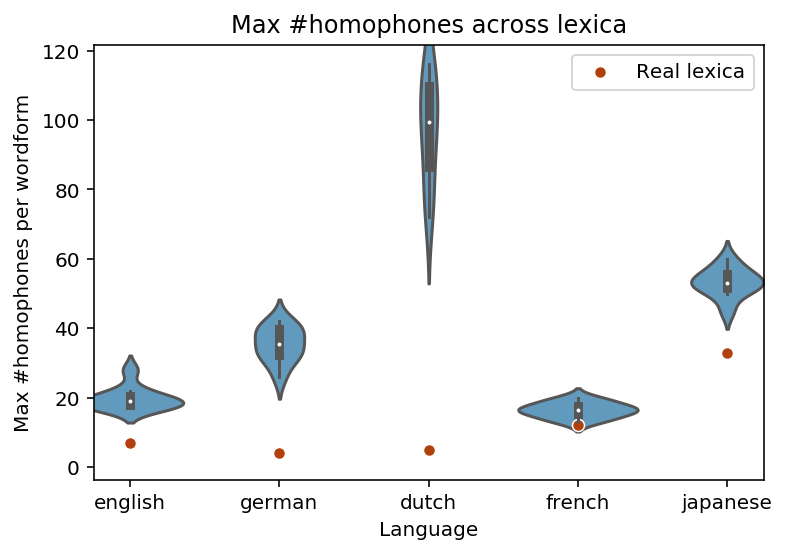

In [20]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'max_homophones',
           # palette = 'Blues',
            color = sns.color_palette("Blues")[3],
               label = "Simulated"
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
                   x = "language",
                   y = 'max_homophones',
                   color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
    
plt.title("Max #homophones across lexica")
plt.ylabel("Max #homophones per wordform")
plt.xlabel("Language")
plt.savefig("Figures/combined/descriptive/max_homophones.png", dpi=400, bbox_inches = "tight")

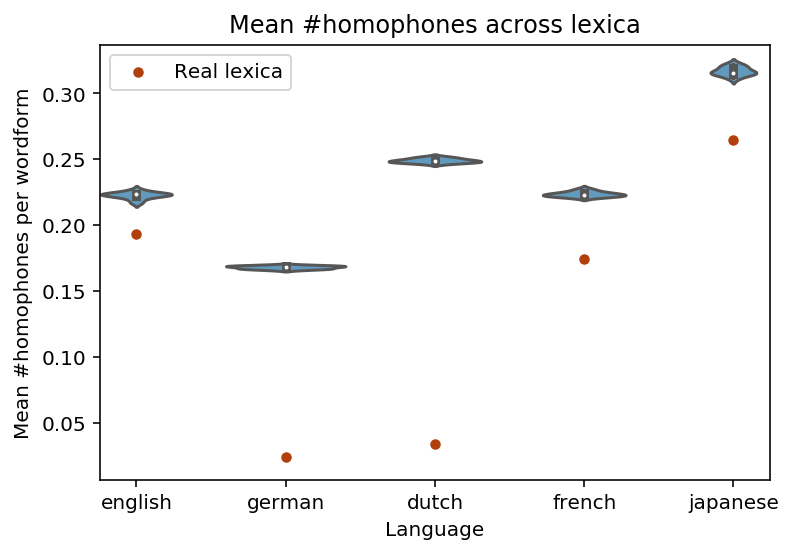

In [21]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'mean_homophones',
           # palette = 'Blues',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
                   x = "language",
           y = 'mean_homophones',
                   color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
    
plt.title("Mean #homophones across lexica")
plt.ylabel("Mean #homophones per wordform")
plt.xlabel("Language")
plt.savefig("Figures/combined/descriptive/mean_homophones.png", dpi=400, bbox_inches = "tight")

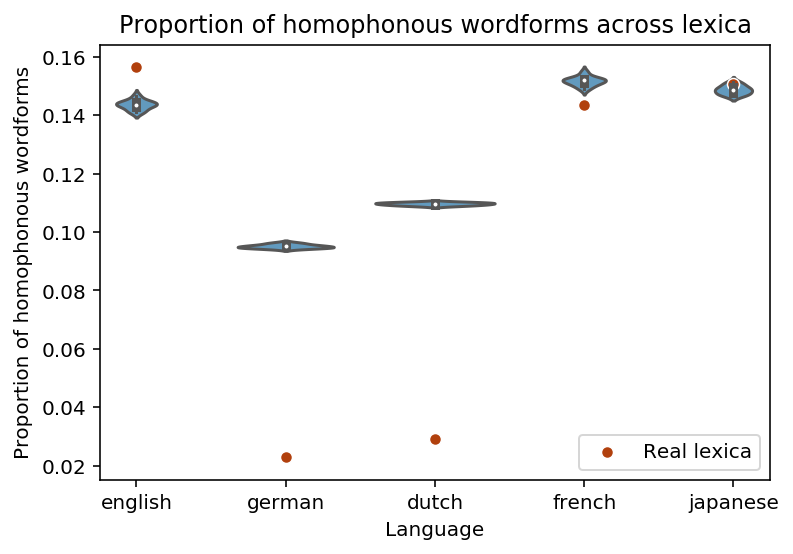

In [22]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'homophone_percentage',
           color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
           x = "language",
           y = 'homophone_percentage',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("Proportion of homophonous wordforms across lexica")
plt.ylabel("Proportion of homophonous wordforms")
plt.xlabel("Language")
plt.savefig("Figures/combined/descriptive/homophony_rate.png", dpi=400, bbox_inches = "tight")

### Descriptive tables

In [23]:
df_descriptive.groupby(["language", "real"]).mean()

homophone_percentage  max_homophones  max_mp  mean_homophones  \
language real                                                                  
dutch    No                 0.10966            97.1    27.3          0.24913   
         Yes                0.02910             5.0    42.0          0.03400   
english  No                 0.14359            19.8    41.9          0.22274   
         Yes                0.15640             7.0    46.0          0.19310   
french   No                 0.15169            16.5    48.9          0.22370   
         Yes                0.14340            12.0    63.0          0.17450   
german   No                 0.09514            35.4    21.6          0.16822   
         Yes                0.02290             4.0    26.0          0.02460   
japanese No                 0.14874            53.2    51.6          0.31691   
         Yes                0.15060            33.0    59.0          0.26450   

               mean_mp  total_mp  
language real                     
dutch    No    1.01865   55026.6  
         Yes   1.49810   97768.0  
english  No    2.27931   78081.8  
         Yes   2.55980   89868.0  
french   No    2.24993   80498.4  
         Yes   2.72400  101547.0  
german   No    0.78248   34642.4  
         Yes   1.01870   51378.0  
japanese No    3.59933  139795.0  
         Yes   4.74890  192090.0

In [24]:
df_descriptive.groupby(["language", "real"]).std()

homophone_percentage  max_homophones    max_mp  \
language real                                                   
dutch    No                0.000462       15.125034  1.888562   
         Yes                    NaN             NaN       NaN   
english  No                0.001610        3.293090  2.183270   
         Yes                    NaN             NaN       NaN   
french   No                0.001551        2.173067  4.121758   
         Yes                    NaN             NaN       NaN   
german   No                0.000642        4.993329  1.264911   
         Yes                    NaN             NaN       NaN   
japanese No                0.001508        4.104198  1.955050   
         Yes                    NaN             NaN       NaN   

               mean_homophones   mean_mp     total_mp  
language real                                          
dutch    No           0.001580  0.010910   600.166681  
         Yes               NaN       NaN          NaN  
english  No           0.002547  0.029703  1082.693124  
         Yes               NaN       NaN          NaN  
french   No           0.001887  0.021465   701.082845  
         Yes               NaN       NaN          NaN  
german   No           0.001140  0.011964   550.931171  
         Yes               NaN       NaN          NaN  
japanese No           0.003245  0.031211  1439.913655  
         Yes               NaN       NaN          NaN

### Minimal pairs

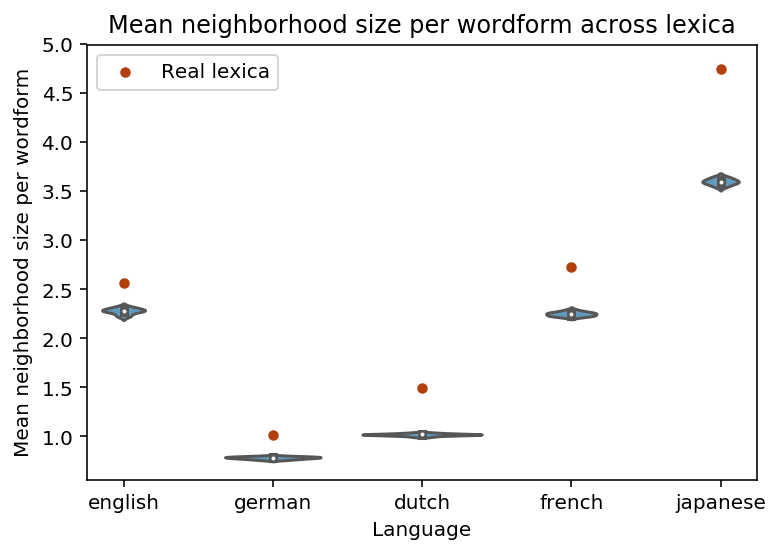

In [25]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'mean_mp',
           color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
           x = "language",
           y = 'mean_mp',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("Mean neighborhood size per wordform across lexica")
plt.ylabel("Mean neighborhood size per wordform")
plt.xlabel("Language")
plt.savefig("Figures/combined/descriptive/mean_mps.png", dpi=400, bbox_inches = "tight")

Text(0.5, 0, 'Language')

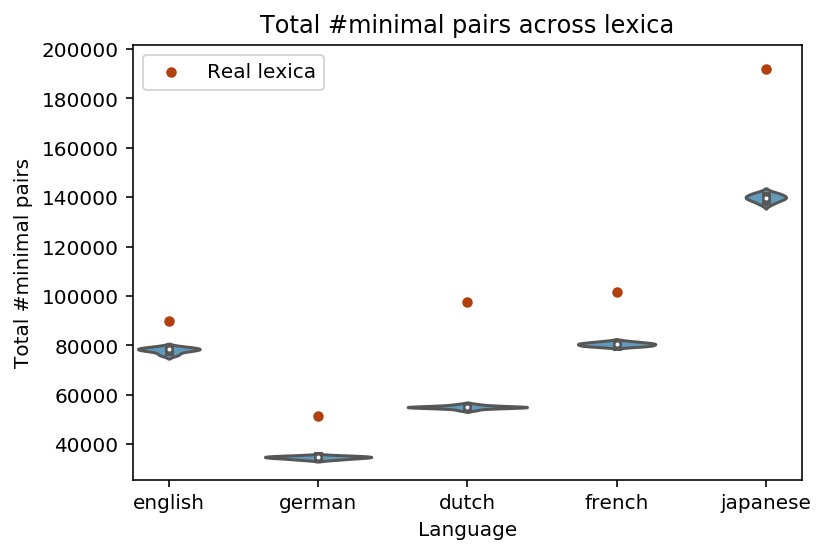

In [26]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'total_mp',
           color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
           x = "language",
           y = 'total_mp',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("Total #minimal pairs across lexica")
plt.ylabel("Total #minimal pairs")
plt.xlabel("Language")
# plt.savefig("Figures/combined/descriptive/total_mps.png", dpi=400, bbox_inches = "tight")

Text(0.5, 0, 'Language')

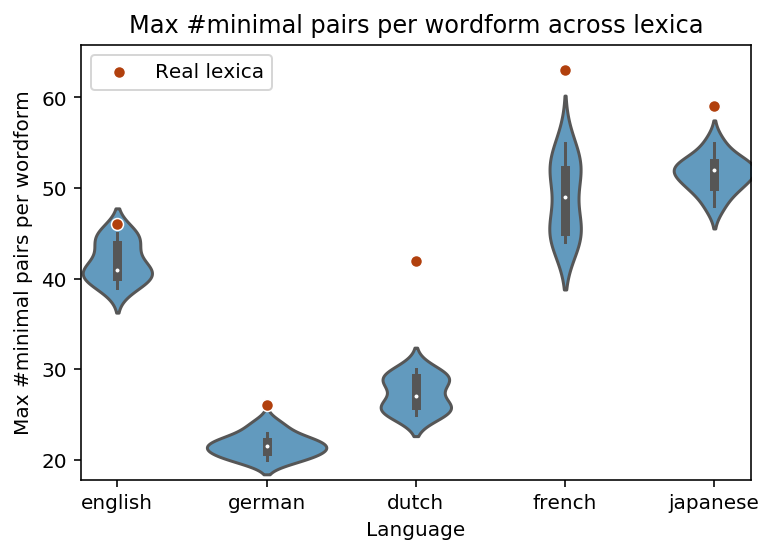

In [27]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'max_mp',
           color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
           x = "language",
           y = 'max_mp',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("Max #minimal pairs per wordform across lexica")
plt.ylabel("Max #minimal pairs per wordform")
plt.xlabel("Language")
# plt.savefig("Figures/combined/descriptive/max_mps.png", dpi=400, bbox_inches = "tight")

## Modeling results

### Model 1: `#homophones ~ #syllables + surprisal`

In [28]:
df_all_model1 = pd.concat(model1_results)

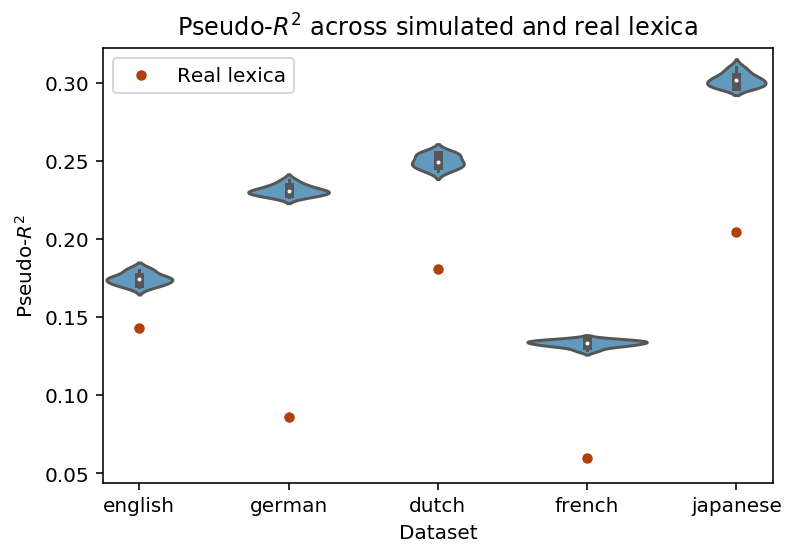

In [30]:
sns.violinplot(data = df_all_model1[df_all_model1['real']=="No"],
           x = "language",
           y = 'pr2',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model1[df_all_model1['real']=="Yes"],
           x = "language",
           y = 'pr2',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )

plt.title("Pseudo-$R^2$ across simulated and real lexica")
plt.ylabel("Pseudo-$R^2$")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/modeling/model1_r2.png", dpi=400, bbox_inches = "tight")

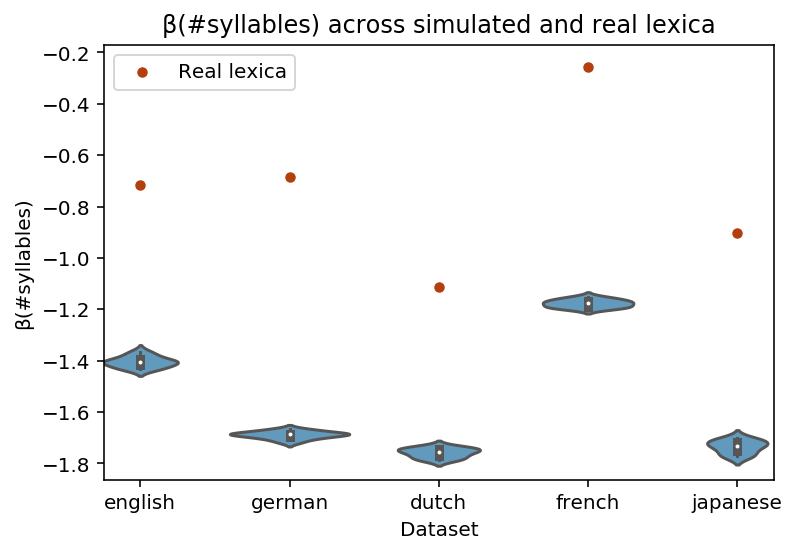

In [32]:
sns.violinplot(data = df_all_model1[df_all_model1['real']=="No"],
           x = "language",
           y = 'num_sylls_est',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model1[df_all_model1['real']=="Yes"],
           x = "language",
           y = 'num_sylls_est',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(#syllables) across simulated and real lexica")
plt.ylabel("\u03B2(#syllables)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/modeling/model1_#sylls.png", dpi=400, bbox_inches = "tight")

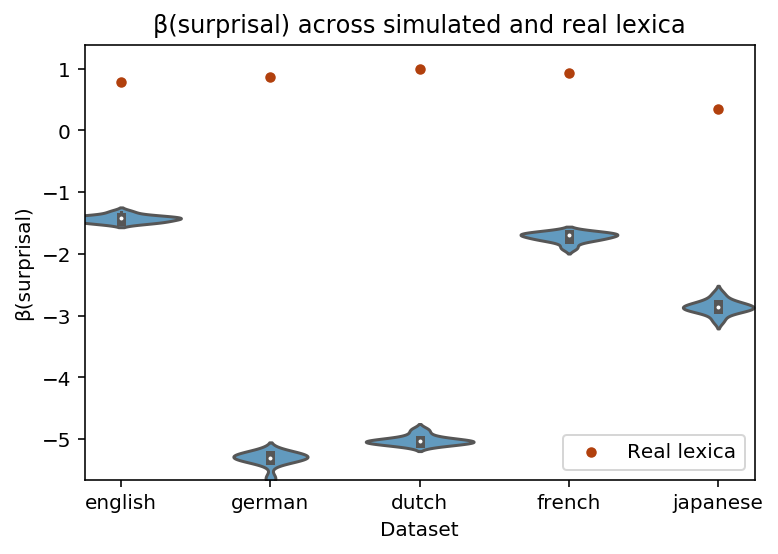

In [33]:
sns.violinplot(data = df_all_model1[df_all_model1['real']=="No"],
           x = "language",
           y = 'surprisal_normed',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model1[df_all_model1['real']=="Yes"],
           x = "language",
           y = 'surprisal_normed',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(surprisal) across simulated and real lexica")
plt.ylabel("\u03B2(surprisal)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/modeling/model1_surprisal.png", dpi=400, bbox_inches = "tight")

### Stats for model 1

In [34]:
df_all_model1.groupby(["language", "real"]).mean()

Intercept  surprisal_normed  num_sylls_est       pr2
language real                                                      
dutch    No     7.175134         -5.013913      -1.758179  0.249705
         Yes   -1.721724          0.997444      -1.111901  0.180386
english  No     2.920846         -1.426311      -1.404238  0.174445
         Yes   -0.837976          0.781546      -0.717063  0.142716
french   No     3.138155         -1.725651      -1.176820  0.133048
         Yes   -1.933540          0.923352      -0.257253  0.059514
german   No     7.127010         -5.316192      -1.688568  0.230932
         Yes   -2.596171          0.860233      -0.685789  0.086204
japanese No     7.338033         -2.859124      -1.734732  0.301680
         Yes    1.353751          0.347172      -0.904112  0.204174

In [35]:
df_all_model1.groupby(["language", "real"]).std()

Intercept  surprisal_normed  num_sylls_est       pr2
language real                                                      
dutch    No     0.095307          0.073824       0.018262  0.004155
         Yes         NaN               NaN            NaN       NaN
english  No     0.088494          0.055047       0.021050  0.003695
         Yes         NaN               NaN            NaN       NaN
french   No     0.096893          0.075799       0.015089  0.002134
         Yes         NaN               NaN            NaN       NaN
german   No     0.120348          0.120383       0.014105  0.003193
         Yes         NaN               NaN            NaN       NaN
japanese No     0.171462          0.108190       0.025263  0.004224
         Yes         NaN               NaN            NaN       NaN

## Supplementary models

### Model 2: `#homophones ~ #syllables + surprisal`

In [36]:
df_all_model2 = pd.concat(model2_results)

Text(0.5, 0, 'Dataset')

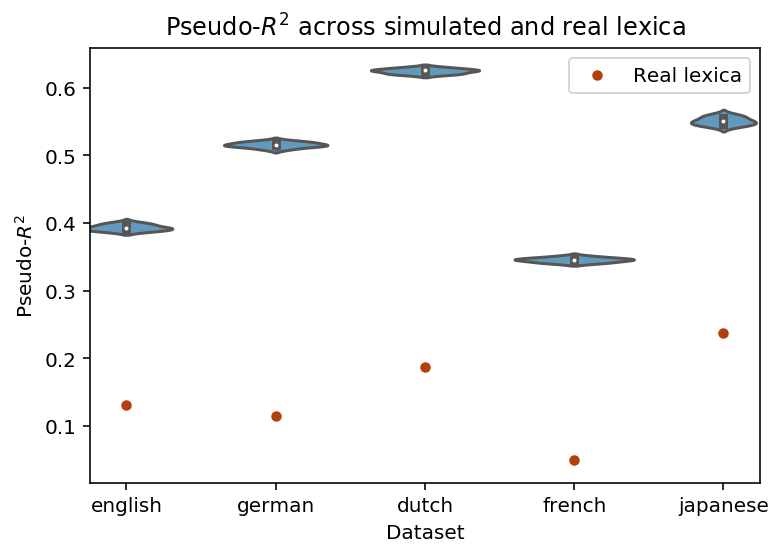

In [37]:
sns.violinplot(data = df_all_model2[df_all_model2['real']=="No"],
           x = "language",
           y = 'pr2',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model2[df_all_model2['real']=="Yes"],
           x = "language",
           y = 'pr2',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )

plt.title("Pseudo-$R^2$ across simulated and real lexica")
plt.ylabel("Pseudo-$R^2$")
plt.xlabel("Dataset")
# plt.savefig("Figures/combined/supplementary/model2_r2.png", dpi=400, bbox_inches = "tight")

Text(0.5, 0, 'Dataset')

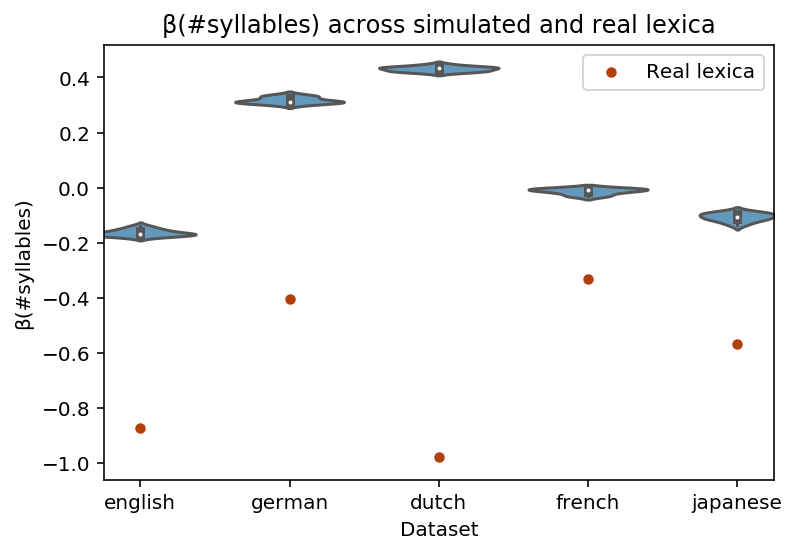

In [38]:
sns.violinplot(data = df_all_model2[df_all_model2['real']=="No"],
           x = "language",
           y = 'num_sylls_est',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model2[df_all_model2['real']=="Yes"],
           x = "language",
           y = 'num_sylls_est',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(#syllables) across simulated and real lexica")
plt.ylabel("\u03B2(#syllables)")
plt.xlabel("Dataset")
# plt.savefig("Figures/combined/supplementary/model2_#sylls.png", dpi=400, bbox_inches = "tight")

Text(0.5, 0, 'Dataset')

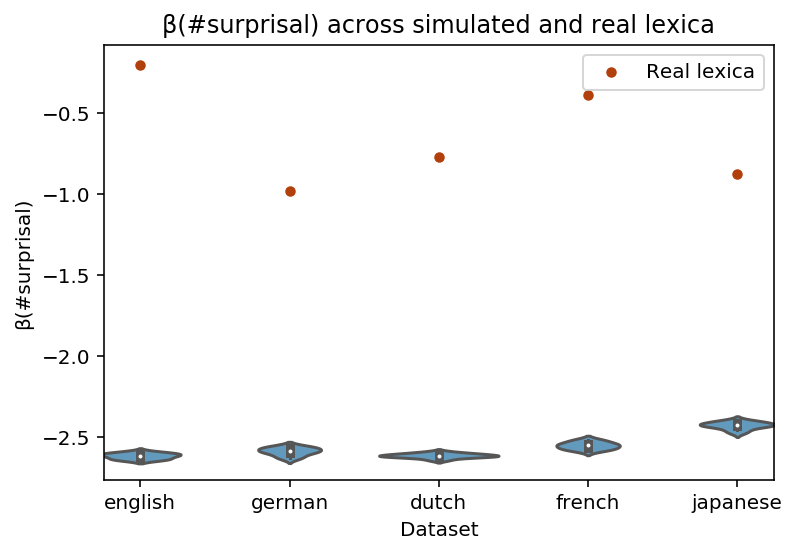

In [39]:
sns.violinplot(data = df_all_model2[df_all_model2['real']=="No"],
           x = "language",
           y = 'surprisal',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model2[df_all_model2['real']=="Yes"],
           x = "language",
           y = 'surprisal',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(#surprisal) across simulated and real lexica")
plt.ylabel("\u03B2(#surprisal)")
plt.xlabel("Dataset")
# plt.savefig("Figures/combined/supplementary/model2_surprisal.png", dpi=400, bbox_inches = "tight")

### Stats for model 2

In [40]:
df_all_model2.groupby(["language", "real"]).mean()

Intercept  surprisal  num_sylls_est       pr2
language real                                               
dutch    No    11.188936  -2.614512       0.431661  0.625005
         Yes    3.204029  -0.773473      -0.978526  0.187051
english  No    12.048830  -2.616651      -0.163649  0.393459
         Yes    1.308477  -0.203636      -0.871333  0.131573
french   No    11.420362  -2.552086      -0.012465  0.345745
         Yes    1.171697  -0.385968      -0.333307  0.050003
german   No    10.924749  -2.588139       0.317405  0.515890
         Yes    2.782169  -0.979246      -0.405047  0.115427
japanese No    11.388934  -2.428421      -0.106470  0.551066
         Yes    5.182131  -0.877087      -0.568710  0.237003

In [41]:
df_all_model2.groupby(["language", "real"]).std()

Intercept  surprisal  num_sylls_est       pr2
language real                                               
dutch    No     0.058164   0.013569       0.008799  0.003506
         Yes         NaN        NaN            NaN       NaN
english  No     0.096460   0.017472       0.011407  0.004296
         Yes         NaN        NaN            NaN       NaN
french   No     0.093630   0.022121       0.010340  0.003266
         Yes         NaN        NaN            NaN       NaN
german   No     0.086856   0.024180       0.011141  0.003793
         Yes         NaN        NaN            NaN       NaN
japanese No     0.090608   0.022078       0.014450  0.005800
         Yes         NaN        NaN            NaN       NaN

# Supplementary analyses: biphone model

In [64]:
def process_and_extract_artificials(df_artificials, N=10):
    """Extract each artificial lexicon from aggregated dataframe.
    
    Also returns information about homophony distribution and minimal pair distribution.
    """
    processed_artificials = []
    homophone_percentages = []
    mean_homophones, max_homophones = [], []
    mean_mp, max_mp, total_mp = [], [], []
    # Neighborhood size with homophones
    mean_mp_hp, max_mp_hp, total_mp_hp = [], [], []
    for i in tqdm(range(N)):

        df_tmp = df_artificials[df_artificials['lexicon']==i]

        df_tmp_processed = utils.preprocess_for_analysis(df_tmp, phon_column="word", word_column="word", verbose=False)
        
        lex_stats = utils.get_homophone_stats(df_tmp_processed)

        homophone_percentages.append(lex_stats['homophone_percentage'])
        mean_homophones.append(lex_stats['mean_homophones'])
        max_homophones.append(lex_stats['max_homophones'])
                
        processed_artificials.append(df_tmp_processed)
    
    return {'processed_dataframes': processed_artificials,
            'homophone_percentage': homophone_percentages,
            'mean_homophones': mean_homophones,
            'max_homophones': max_homophones
           }
    

## English

In [66]:
df_real = pd.read_csv("data/processed/english/english_all_reals_2phone.csv")
df_lemmas = pd.read_csv("data/processed/english/english_lemmas_processed_2phone.csv")
df_artificials = pd.read_csv("data/processed/english/english_artificial_10_matched_on_sylls_no_restriction_2phone.csv")


In [67]:
english_stats = utils.get_homophone_stats(df_lemmas)

### Preprocess artificials

In [68]:
info_for_english = process_and_extract_artificials(df_artificials)

100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


In [69]:
processed_artificials = info_for_english['processed_dataframes']

#### Norm surprisal

In [70]:
df_lemmas['surprisal_normed'] = df_lemmas['surprisal'] / df_lemmas['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

## Descriptive

In [71]:
max_m = round(np.mean(info_for_english['max_homophones']), 2)
max_std = round(np.std(info_for_english['max_homophones']), 3)
print("Max homophony: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = max_m, max_std=max_std))
print("Real: {m}".format(m = english_stats['max_homophones']))

Max homophony: 
Artificial: M = 434.3, SD = 26.272
Real: 7


In [72]:
mean_m = round(np.mean(info_for_english['mean_homophones']), 2)
mean_std = round(np.std(info_for_english['mean_homophones']), 3)
print("Mean homophony: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = mean_m, max_std=mean_std))
print("Real: {m}".format(m = english_stats['mean_homophones']))

Mean homophony: 
Artificial: M = 0.13, SD = 0.001
Real: 0.1931


In [73]:
prop_m = round(np.mean(info_for_english['homophone_percentage']), 2)
prop_std = round(np.std(info_for_english['homophone_percentage']), 4)
print("Proportion of homophonous wordforms: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = prop_m, max_std=prop_std))
print("Real: {m}".format(m = english_stats['homophone_percentage']))

Proportion of homophonous wordforms: 
Artificial: M = 0.04, SD = 0.0004
Real: 0.1564


## Modeling

### `num_homophones ~ #sylls + surprisal_normalized`

In [74]:
# Set up models
TARGET_MODEL_1 = 'num_homophones'
COVARIATES_MODEL_1 = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA_MODEL_1 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_1, regressors=' + '.join(COVARIATES_MODEL_1))

In [75]:
# Run model 1
df_analysis = analyze_stats(df_lemmas, processed_artificials, formula=FORMULA_MODEL_1, 
                            covariates=COVARIATES_MODEL_1)
df_analysis['language'] = ['english' for i in range(len(df_analysis))]

In [76]:
df_analysis.groupby(["language", "real"]).mean()

Intercept  surprisal_normed  num_sylls_est       pr2
language real                                                      
english  No     4.230504         -1.050552      -2.542480  0.304853
         Yes    0.264016          0.104042      -0.944182  0.130236

In [77]:
df_analysis.groupby(["language", "real"]).std()

Intercept  surprisal_normed  num_sylls_est       pr2
language real                                                      
english  No      0.14839          0.108901       0.031269  0.003768
         Yes         NaN               NaN            NaN       NaN

### `num_homophones ~ #sylls + normalized_surprisal`

In [78]:
# Set up models
TARGET_MODEL_1 = 'num_homophones'
COVARIATES_MODEL_1 = [
    'surprisal',
    'num_sylls_est',
]
FORMULA_MODEL_1 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_1, regressors=' + '.join(COVARIATES_MODEL_1))

In [79]:
# Run model 1
df_analysis = analyze_stats(df_lemmas, processed_artificials, formula=FORMULA_MODEL_1, 
                            covariates=COVARIATES_MODEL_1)
df_analysis['language'] = ['english' for i in range(len(df_analysis))]

In [80]:
df_analysis.groupby(["language", "real"]).mean()

Intercept  surprisal  num_sylls_est       pr2
language real                                               
english  No     9.612628  -2.536192       1.284275  0.807300
         Yes    1.232360  -0.207295      -0.555806  0.144239

In [81]:
df_analysis.groupby(["language", "real"]).std()

Intercept  surprisal  num_sylls_est       pr2
language real                                               
english  No     0.047587   0.012269       0.026304  0.003401
         Yes         NaN        NaN            NaN       NaN

## Japanese

In [82]:
df_real = pd.read_csv("data/processed/japanese/japanese_all_reals_2phone.csv")
df_lemmas = pd.read_csv("data/processed/japanese/japanese_lemmas_processed_2phone.csv")
df_artificials = pd.read_csv("data/processed/japanese/japanese_artificial_10_matched_on_sylls_no_restriction_2phone.csv")


In [83]:
japanese_stats = utils.get_homophone_stats(df_lemmas)

### Preprocess artificials

In [84]:
info_for_japanese = process_and_extract_artificials(df_artificials)

100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


In [85]:
processed_artificials = info_for_japanese['processed_dataframes']

#### Norm surprisal

In [86]:
df_lemmas['surprisal_normed'] = df_lemmas['surprisal'] / df_lemmas['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

## Descriptive

In [87]:
max_m = round(np.mean(info_for_japanese['max_homophones']), 2)
max_std = round(np.std(info_for_japanese['max_homophones']), 3)
print("Max homophony: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = max_m, max_std=max_std))
print("Real: {m}".format(m = japanese_stats['max_homophones']))

Max homophony: 
Artificial: M = 89.6, SD = 7.902
Real: 33


In [88]:
mean_m = round(np.mean(info_for_japanese['mean_homophones']), 2)
mean_std = round(np.std(info_for_japanese['mean_homophones']), 3)
print("Mean homophony: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = mean_m, max_std=mean_std))
print("Real: {m}".format(m = japanese_stats['mean_homophones']))

Mean homophony: 
Artificial: M = 0.17, SD = 0.002
Real: 0.2645


In [89]:
prop_m = round(np.mean(info_for_japanese['homophone_percentage']), 2)
prop_std = round(np.std(info_for_japanese['homophone_percentage']), 4)
print("Proportion of homophonous wordforms: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = prop_m, max_std=prop_std))
print("Real: {m}".format(m = japanese_stats['homophone_percentage']))

Proportion of homophonous wordforms: 
Artificial: M = 0.06, SD = 0.0007
Real: 0.1506


## Modeling

### `num_homophones ~ #sylls + surprisal_normalized`

In [90]:
# Set up models
TARGET_MODEL_1 = 'num_homophones'
COVARIATES_MODEL_1 = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA_MODEL_1 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_1, regressors=' + '.join(COVARIATES_MODEL_1))

In [91]:
# Run model 1
df_analysis = analyze_stats(df_lemmas, processed_artificials, formula=FORMULA_MODEL_1, 
                            covariates=COVARIATES_MODEL_1)
df_analysis['language'] = ['japanese' for i in range(len(df_analysis))]

In [93]:
df_analysis.groupby(["language", "real"]).mean()

Intercept  surprisal_normed  num_sylls_est       pr2
language real                                                      
japanese No     9.577225         -3.578190      -2.432676  0.439138
         Yes    4.650302         -1.699234      -1.190803  0.220175

In [94]:
df_analysis.groupby(["language", "real"]).std()

Intercept  surprisal_normed  num_sylls_est       pr2
language real                                                      
japanese No     0.169254          0.123031       0.014904  0.002325
         Yes         NaN               NaN            NaN       NaN

### `num_homophones ~ #sylls + surprisal`

In [95]:
# Set up models
TARGET_MODEL_1 = 'num_homophones'
COVARIATES_MODEL_1 = [
    'surprisal',
    'num_sylls_est',
]
FORMULA_MODEL_1 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_1, regressors=' + '.join(COVARIATES_MODEL_1))

In [96]:
# Run model 1
df_analysis = analyze_stats(df_lemmas, processed_artificials, formula=FORMULA_MODEL_1, 
                            covariates=COVARIATES_MODEL_1)
df_analysis['language'] = ['japanese' for i in range(len(df_analysis))]

In [97]:
df_analysis.groupby(["language", "real"]).mean()

Intercept  surprisal  num_sylls_est       pr2
language real                                               
japanese No     8.127253  -2.547732       1.415252  0.722050
         Yes    3.723139  -0.795718       0.064136  0.278735

In [98]:
df_analysis.groupby(["language", "real"]).std()

Intercept  surprisal  num_sylls_est       pr2
language real                                               
japanese No     0.033093   0.023547       0.030669  0.002845
         Yes         NaN        NaN            NaN       NaN

# Supplementary analysis: held-out surprisal

Use leave-one-out to calculate surprisal for wordforms in the real lexicon, rather than including all items in the initial language model.

In [11]:
from src.generative_model import NgramModel
from sklearn.model_selection import LeaveOneOut, train_test_split, KFold


In [25]:
def create_model(wordforms, n=5, smoothing=.01):
    """Create n-gram model."""
    lm = NgramModel(n, wordforms, 1)
    lm.create_model(wordforms, smoothing)
    return lm

In [98]:
def calculate_heldout_surprisal(wordforms, num_folds=NUM_FOLDS):
    """Calculate surprisal using k-fold cross-validation for the real lexicon."""
    held_out_data = []

    kf = KFold(n_splits=num_folds)

    splits = list(kf.split(wordforms))

    for train_indices, test_indices in tqdm(splits):

        train = wordforms[train_indices]
        test = wordforms[test_indices]

        lm = create_model(train)

        for i in test:
            held_out_data.append({
                'word': i,
                'heldout_surprisal': -lm.evaluate(i)[-1]
            })
    
    return pd.DataFrame(held_out_data)

In [100]:
languages = ['english', 'german', 'dutch', 'french', 'japanese']

In [105]:
# Set up models
TARGET_MODEL_1 = 'num_homophones'
COVARIATES_MODEL_1 = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA_MODEL_1 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_1, regressors=' + '.join(COVARIATES_MODEL_1))

In [106]:
#Supplementary models: non-normed surprisal
TARGET_MODEL_2 = 'num_homophones'
COVARIATES_MODEL_2 = [
    'surprisal',
    'num_sylls_est',
]
FORMULA_MODEL_2 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_2, regressors=' + '.join(COVARIATES_MODEL_2))

In [107]:
NUM_FOLDS = 5

In [108]:
model1_results = []
model2_results = []
descriptive_stats = []

for language in languages:
    print("Loading lexica for {language}...".format(language=language))
    phon_column = config.PHON_COLUMN[language]
    word_column = config.WORD_COLUMN[language]
    df_og, df_processed, df_artificials = load_lexicons_for_language(language, phon_column=phon_column,
                                                                     word_column=word_column)
    
    # Process artificial lexica
    print("Processing artificial lexica...")
    language_info = process_and_extract_artificials(df_artificials)
    processed_artificials = language_info.pop('processed_dataframes')
    
    # Get heldout surprisal
    print("Calculating heldout surprisal...")
    df_real_heldout = calculate_heldout_surprisal(df_processed[phon_column].values, num_folds=NUM_FOLDS)
    df_real_heldout[phon_column] = df_real_heldout['word']
    
    # Merge with real processed lexicon
    df_merged = pd.merge(df_processed, df_real_heldout, on=phon_column)
    print(len(df_processed))
    print(len(df_merged))
    
    # Create normed surprisal column
    df_merged['surprisal_normed'] = df_merged['heldout_surprisal'] / df_merged['num_phones']
    for i in processed_artificials:
        i['surprisal_normed'] = i['surprisal'] / i['num_phones']
        
    ####### Get descriptive statistics #######
    stats_real = get_stats_for_lexicon(df_merged)
    stats_real['language'] = language
    stats_real['real'] = "Yes"
    descriptive_stats.append(pd.DataFrame([stats_real]))
    
    # Add descriptive statistics from artificial lexica
    simulated_stats = pd.DataFrame(language_info)
    simulated_stats['language'] = [language for i in range(len(simulated_stats))]
    simulated_stats['real'] = ["No" for i in range(len(simulated_stats))]
    descriptive_stats.append(simulated_stats)
    
    ####### Statistical modeling #######
    
    # Run model 1
    df_analysis = analyze_stats(df_merged, processed_artificials, formula=FORMULA_MODEL_1, 
                                covariates=COVARIATES_MODEL_1)
    df_analysis['language'] = [language for i in range(len(df_analysis))]
    # Add model 1 data
    model1_results.append(df_analysis)
    
    # Run model 2
    """
    df_analysis = analyze_stats(df_merged, processed_artificials, formula=FORMULA_MODEL_2, 
                                covariates=COVARIATES_MODEL_2)
    df_analysis['language'] = [language for i in range(len(df_analysis))]
    # Add model 2 data
    model2_results.append(df_analysis)
    """

Loading lexica for english...


  0%|          | 0/10 [00:00<?, ?it/s]

Processing artificial lexica...


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating heldout surprisal...


100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


35107
35107
Loading lexica for german...


  0%|          | 0/10 [00:00<?, ?it/s]

Processing artificial lexica...


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating heldout surprisal...


100%|██████████| 5/5 [00:19<00:00,  4.09s/it]


50435
50435
Loading lexica for dutch...


  0%|          | 0/10 [00:00<?, ?it/s]

Processing artificial lexica...


 30%|███       | 3/10 [00:03<00:07,  1.02s/it]/Users/seantrott/Dropbox/UCSD/Research/Ambiguity/Evolution/homophone_simulations/src/utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['remove'] = df[word_column].apply(remove_word)
  0%|          | 0/5 [00:00<?, ?it/s]

Calculating heldout surprisal...


100%|██████████| 5/5 [00:23<00:00,  4.63s/it]


65260
65260
Loading lexica for french...


  0%|          | 0/10 [00:00<?, ?it/s]

Processing artificial lexica...


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating heldout surprisal...


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


37278
37278
Loading lexica for japanese...


  0%|          | 0/10 [00:00<?, ?it/s]

Processing artificial lexica...


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating heldout surprisal...


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


40449
40449


## Modeling results: supplementary analysis with heldout surprisal

### Model 1: `#homophones ~ #syllables + normalized_surprisal`

In [109]:
df_all_model1 = pd.concat(model1_results)

/Users/seantrott/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'Dataset')

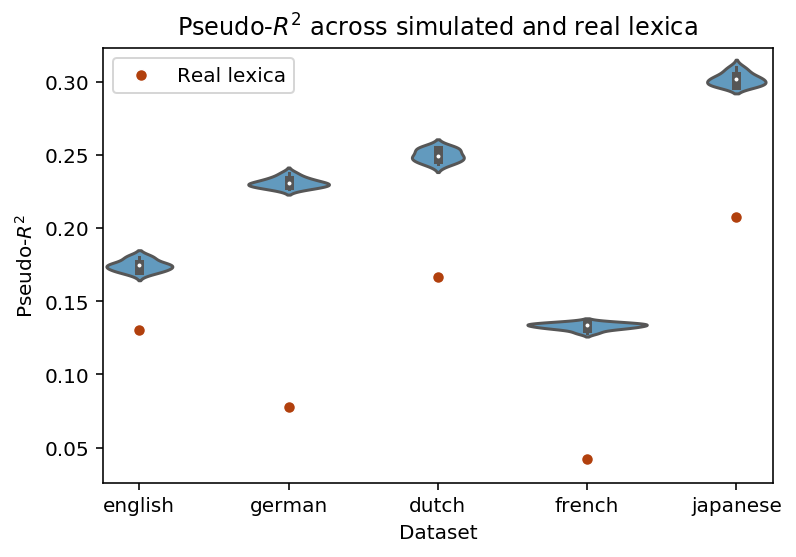

In [110]:
sns.violinplot(data = df_all_model1[df_all_model1['real']=="No"],
           x = "language",
           y = 'pr2',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model1[df_all_model1['real']=="Yes"],
           x = "language",
           y = 'pr2',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )

plt.title("Pseudo-$R^2$ across simulated and real lexica")
plt.ylabel("Pseudo-$R^2$")
plt.xlabel("Dataset")
# plt.savefig("Figures/combined/modeling/model1_r2.png", dpi=400, bbox_inches = "tight")

Text(0.5, 0, 'Dataset')

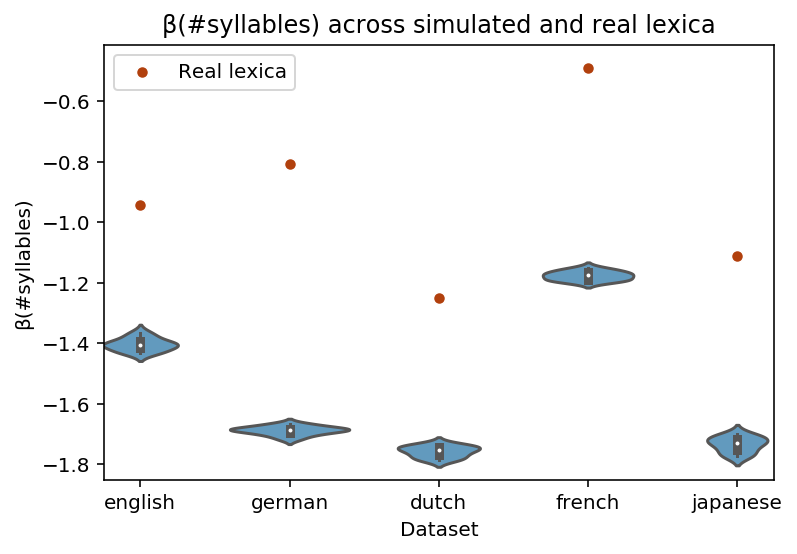

In [111]:
sns.violinplot(data = df_all_model1[df_all_model1['real']=="No"],
           x = "language",
           y = 'num_sylls_est',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model1[df_all_model1['real']=="Yes"],
           x = "language",
           y = 'num_sylls_est',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(#syllables) across simulated and real lexica")
plt.ylabel("\u03B2(#syllables)")
plt.xlabel("Dataset")
# plt.savefig("Figures/combined/modeling/model1_#sylls.png", dpi=400, bbox_inches = "tight")

Text(0.5, 0, 'Dataset')

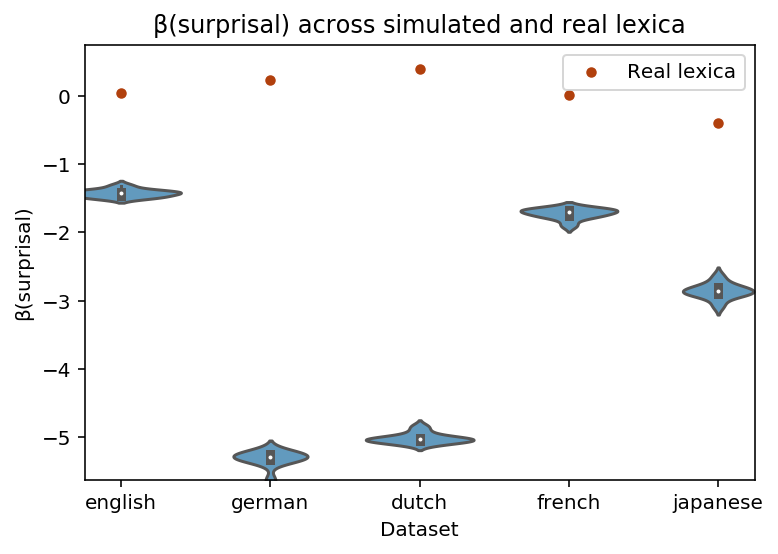

In [112]:
sns.violinplot(data = df_all_model1[df_all_model1['real']=="No"],
           x = "language",
           y = 'surprisal_normed',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model1[df_all_model1['real']=="Yes"],
           x = "language",
           y = 'surprisal_normed',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(surprisal) across simulated and real lexica")
plt.ylabel("\u03B2(surprisal)")
plt.xlabel("Dataset")
# plt.savefig("Figures/combined/modeling/model1_surprisal.png", dpi=400, bbox_inches = "tight")

### Stats for model 1

In [113]:
df_all_model1.groupby(["language", "real"]).mean()

Intercept  surprisal_normed  num_sylls_est       pr2
language real                                                      
dutch    No     7.175134         -5.013913      -1.758179  0.249705
         Yes   -1.305233          0.386925      -1.252352  0.166609
english  No     2.920846         -1.426311      -1.404238  0.174445
         Yes    0.321018          0.041308      -0.942228  0.130213
french   No     3.138155         -1.725651      -1.176820  0.133048
         Yes   -0.472952          0.012231      -0.489312  0.042540
german   No     7.127010         -5.316192      -1.688568  0.230932
         Yes   -1.977267          0.227401      -0.806992  0.077733
japanese No     7.338033         -2.859124      -1.734732  0.301680
         Yes    2.938982         -0.403143      -1.110702  0.207510

In [35]:
df_all_model1.groupby(["language", "real"]).std()

Intercept  surprisal_normed  num_sylls_est       pr2
language real                                                      
dutch    No     0.095307          0.073824       0.018262  0.004155
         Yes         NaN               NaN            NaN       NaN
english  No     0.088494          0.055047       0.021050  0.003695
         Yes         NaN               NaN            NaN       NaN
french   No     0.096893          0.075799       0.015089  0.002134
         Yes         NaN               NaN            NaN       NaN
german   No     0.120348          0.120383       0.014105  0.003193
         Yes         NaN               NaN            NaN       NaN
japanese No     0.171462          0.108190       0.025263  0.004224
         Yes         NaN               NaN            NaN       NaN